In [1]:
# British Election Study dataset

# Very big (30,000+), multiple waves (we're up to 9 now) tracking some of the same people
#





In [42]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy import stats

In [3]:
%%time
# Load BES Panel for Wave 8
BES_Panel = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.3.dta")
#(31409, 733)

# BES_Panel = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

(31409, 733)
Wall time: 12.6 s


In [5]:
a = BES_Panel.columns

In [421]:
[x for x in a if "vote" in x]

['voted2015',
 'voteMethodW9',
 'profile_past_vote_2005',
 'profile_past_vote_2010',
 'profile_past_vote_2015']

In [8]:
[x for x in a if "2015" in x]

['voted2015', 'profile_turnout_2015', 'profile_past_vote_2015']

In [17]:
nans = BES_Panel[['profile_past_vote_2010', 'profile_past_vote_2015']].isnull().any(axis=1)

In [20]:
vote_change = BES_Panel[['profile_past_vote_2010', 'profile_past_vote_2015']][~nans]
vote_change.columns = [ "2010","2015" ]

In [21]:
vote_change['profile_past_vote_2010'].value_counts()

Conservative Party                          7302
Labour Party                                5475
Liberal Democrats                           4698
Did not vote                                1669
Scottish National Party                      896
United Kingdom Independence Party (UKIP)     727
Don't know                                   425
Green Party                                  285
Plaid Cymru                                  213
British National Party (BNP)                 200
Some other party                             199
Respect                                        4
Name: profile_past_vote_2010, dtype: int64

In [416]:
BES_Panel['profile_past_vote_2005'].loc[ld_minus_ukip].value_counts()

Liberal Democrats                           2042
Labour Party                                 907
Did not vote                                 296
Conservative Party                           249
Don't know                                   160
Green Party                                   81
Scottish National Party                       48
Plaid Cymru                                   31
United Kingdom Independence Party (UKIP)      28
Some other party                              21
British National Party (BNP)                   4
Respect                                        3
Veritas                                        0
Name: profile_past_vote_2005, dtype: int64

In [26]:
vote_change[ vote_change["2010"] == "British National Party (BNP)" ]["2015"].value_counts()

United Kingdom Independence Party (UKIP)    132
Conservative                                 26
Labour                                       21
Scottish National Party (SNP)                 6
Green Party                                   5
Don't know                                    4
Other                                         3
British National Party (BNP)                  2
Liberal Democrat                              1
Plaid Cymru                                   0
Name: 2015, dtype: int64

In [27]:
vote_change[ vote_change["2010"] == "United Kingdom Independence Party (UKIP)" ]["2015"].value_counts()

United Kingdom Independence Party (UKIP)    482
Conservative                                124
Labour                                       50
Other                                        19
Green Party                                  17
Liberal Democrat                             15
Scottish National Party (SNP)                 8
Don't know                                    7
Plaid Cymru                                   4
British National Party (BNP)                  1
Name: 2015, dtype: int64

In [28]:
vote_change[ vote_change["2010"] == "Liberal Democrats" ]["2015"].value_counts()

Labour                                      1435
Liberal Democrat                            1239
Conservative                                 700
Green Party                                  493
United Kingdom Independence Party (UKIP)     431
Scottish National Party (SNP)                243
Other                                         78
Plaid Cymru                                   48
Don't know                                    25
British National Party (BNP)                   6
Name: 2015, dtype: int64

In [197]:
ld_ukip = vote_change[ (vote_change["2010"] == "Liberal Democrats")
            & (vote_change["2015"] =="United Kingdom Independence Party (UKIP)") ].index

ld = vote_change[ (vote_change["2010"] == "Liberal Democrats") ].index

ld_minus_ukip = vote_change[ (vote_change["2010"] == "Liberal Democrats")
            & (vote_change["2015"] !="United Kingdom Independence Party (UKIP)") ].index

In [200]:
BES_Panel.loc[ld_ukip].lr_scale.cat.codes.mean(), BES_Panel.loc[ld_minus_ukip].lr_scale.cat.codes.mean()

(3.8932714617169375, 4.7333020857745485)

In [199]:
BES_Panel.loc[ld_ukip].al_scale.cat.codes.mean(), BES_Panel.loc[ld_minus_ukip].al_scale.cat.codes.mean()

(14.491879350348027, 10.220529646121397)

In [47]:
and_stat = stats.anderson_ksamp( [ BES_Panel.loc[ld_ukip].al_scale.cat.codes.values,  BES_Panel.loc[ld].al_scale.cat.codes.values ] )

C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [50]:
and_stat

Anderson_ksampResult(statistic=176.84941235866381, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=1.7000140912547025e+263)

In [51]:
and_stat.significance_level

1.7000140912547025e+263

In [182]:
signif_array = pd.DataFrame(columns = [ "variable","significance" ])
overrun_errors = []
ind = 0
for col in BES_Panel.columns:
    if BES_Panel[col].dtypes.name =="category":
        if (BES_Panel.loc[ld_ukip][col].cat.codes.var()!=0.0)\
        & (BES_Panel.loc[ld][col].cat.codes.var()!=0.0):
            try:
                and_stat = stats.anderson_ksamp( [BES_Panel.loc[ld_ukip][col].cat.codes.values,
                                                  BES_Panel.loc[ld][col].cat.codes.values ] )
                signif_array.loc[ind] = [col, and_stat.significance_level ]
#                 signif_array.append( and_stat.significance_level )
            except:
                overrun_errors.append( col )
                print( ("****", col, "****" ) )
                signif_array.loc[ind] = [col, -1 ]
        else:
#             signif_array.append(99999999)
            signif_array.loc[ind] = [col, 99999999 ]
    ind = ind+1    
signif_array

C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'euRefVote', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'europeanness', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'likeFarage', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'likeBoris', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'likeUKIP', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'changeImmig', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'EUIntegrationSelf', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'ukCoopTrade', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'ukCoopWorkers', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'ukCoopMovement', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUUnemployment', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUTrade', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUImmigration', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUTerror', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euLeaveVoice', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUWorkers', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUEcon', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'effectsEUNHS', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euLeaveBigBusiness', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'britainFairShare', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euPreventWar', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euUKRich', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euCloser', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'UKsovereignty', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'turkey', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euParlOverRide', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euLawsLevel', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'echr', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'normEU', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euUndermineIdentity', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'immigrantsWelfareState', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'satDemEU', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'immigEcon', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'immigCultural', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'asylumMore', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'euMore', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'familiesMore', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'immigSelf', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'recallVote15', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'euRefVoteW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'happyEULeaveW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'likeFarageW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'likeUKIPW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_1W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_2W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_3W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_4W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_5W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_6W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_7W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_8W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_12W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'blameLeave_99W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_1W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_2W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_3W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_4W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_5W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_6W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_7W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_8W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_12W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'creditLeave_99W9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


('****', 'approveEUW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'EUIntegrationSelfW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'ptvUKIPW9', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

('****', 'al2', '****')


C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be comp

,variable,significance
10,country,9.859833e-05
11,generalElectionVote,1.660285e+206
13,generalElectionVoteW9,2.565097e-01
15,partyId,8.327190e+07
16,partyIdSqueeze,1.007337e-02
18,partyIdEU,1.043513e+236
19,partyIdW9,8.611819e-06
20,partyIdSqueezeW9,2.743437e-02
22,partyIdEUretroW9,1.391474e+23
23,countryOfBirth,4.026867e-02


In [212]:
[x for x in BES_Panel if "personality" in x]

['personality_agreeableness',
 'personality_conscientiousness',
 'personality_extraversion',
 'personality_neuroticism',
 'personality_openness']

7.0     95
8.0     90
5.0     72
6.0     63
10.0    43
9.0     28
3.0     10
2.0     10
4.0      9
Name: personality_conscientiousness, dtype: int64

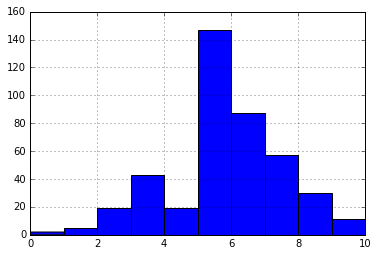

In [226]:
BES_Panel.loc[ld_ukip,'personality_openness'].hist(bins=np.linspace(0,10,11))

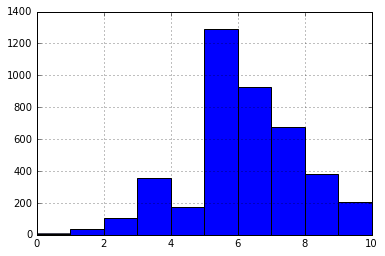

In [227]:
BES_Panel.loc[ld_minus_ukip,'personality_openness'].hist(bins=np.linspace(0,10,11))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B8D0400>]], dtype=object)

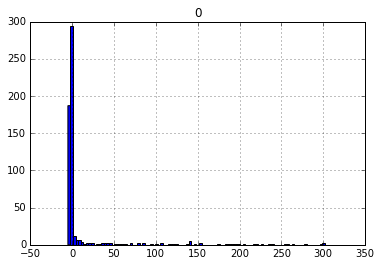

In [109]:
pd.DataFrame(signif_array_copy).apply(np.log10).hist(bins=100)

In [130]:
significant_values = pd.DataFrame(signif_array_copy)[0].values<.05/600

In [131]:
BES_Panel.columns[significant_values]

C:\ANACON~1\envs\BES_analysis\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 733 but corresponding boolean dimension is 575
  result = getitem(key)


Index(['wt_full_W9', 'generalElectionVoteOth', 'generalElectionVoteW9',
       'generalElectionVoteOthW9', 'partyIdSqueeze', 'partyIdEU',
       'partyIdSqueezeOthW9', 'w7core', 'otherCitizen', 'euRefVote',
       'euRefVoteSqueeze', 'polAttention', 'likeBennett', 'likeBoris',
       'likeGove', 'likeOsborne', 'likeLD', 'likeSNP', 'localElectionVote',
       'welshElectionVoteListOth', 'pccVote2', 'EUIntegrationSelf',
       'certaintyEUSNP', 'betterDealEU', 'benefitsToMigrants',
       'childBenefitsRepatriate', 'ukCoopWorkers', 'ukCoopCAP',
       'ukCoopMovement', 'ukCoopEuro', 'effectsEUUnemployment',
       'effectsEUTrade', 'effectsEUImmigration', 'effectsEUTerror',
       'euLeaveVoice', 'certaintyUKRemain', 'businessSupport', 'tuSupport',
       'labSupport', 'conSupport', 'ldSupport', 'snpSupport', 'plaidSupport',
       'parliamentSupport', 'cabinetSupport', 'franceFairShare',
       'britainFairShare', 'germanyFairShare', 'euPreventWar',
       'partyContactCon', 'partyConta

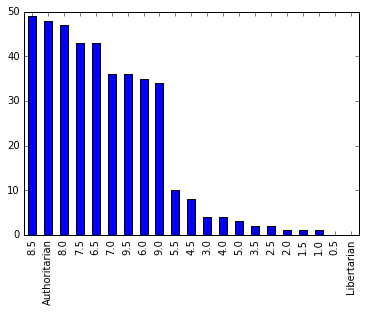

In [196]:
BES_Panel.loc[ld_ukip,'al_scale'].value_counts().plot('bar')

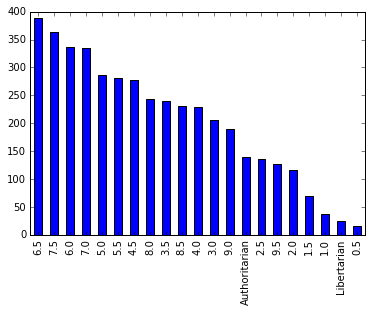

In [195]:
BES_Panel.loc[ld,'al_scale'].value_counts().plot('bar')

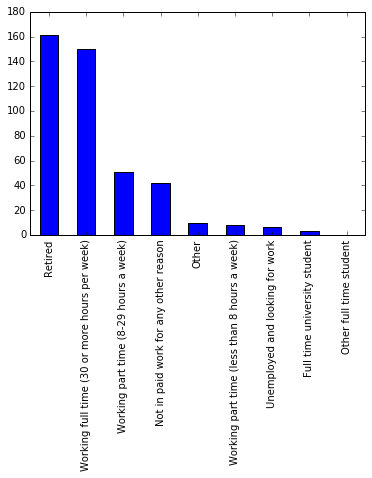

In [194]:
BES_Panel.loc[ld_ukip,'workingStatus'].value_counts().plot('bar')

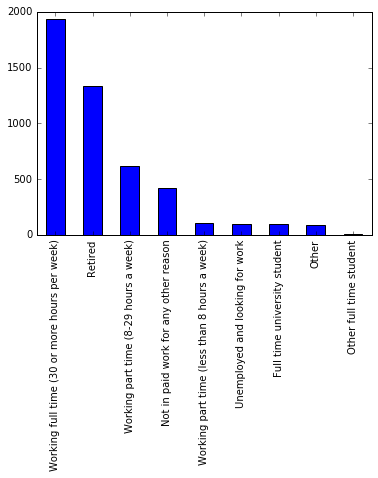

In [193]:
BES_Panel.loc[ld,'workingStatus'].value_counts().plot('bar')

In [174]:
col = 'tolUncertain3'
and_stat = stats.anderson_ksamp( [BES_Panel.loc[ld_ukip][col].cat.codes.values,
                                                  BES_Panel.loc[ld][col].cat.codes.values ] )

C:\ANACON~1\envs\BES_analysis\lib\site-packages\scipy\stats\morestats.py:1684: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [175]:
and_stat

Anderson_ksampResult(statistic=-0.71178333267941751, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.7393851055015579)

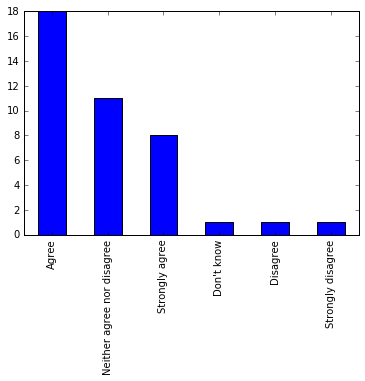

In [164]:
BES_Panel.loc[ld_ukip,'antiIntellectual'].value_counts().plot('bar')

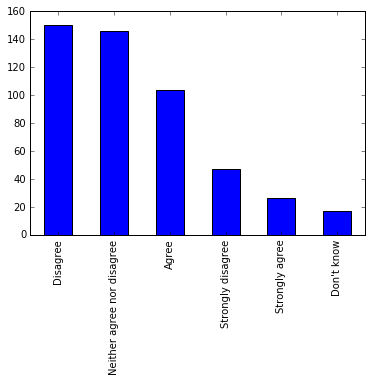

In [165]:
BES_Panel.loc[ld,'antiIntellectual'].value_counts().plot('bar')

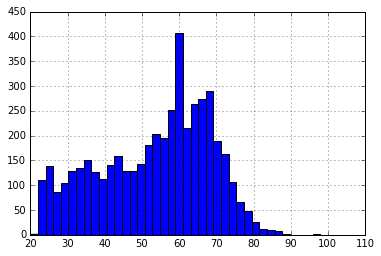

In [152]:
BES_Panel.loc[ld,"age"].hist(bins=np.linspace(20,100,40))

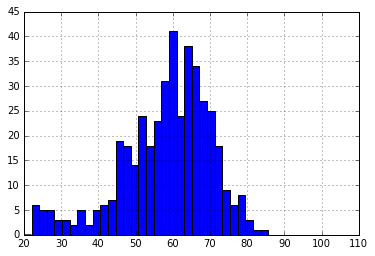

In [151]:
BES_Panel.loc[ld_ukip,"age"].hist(bins=np.linspace(20,100,40))

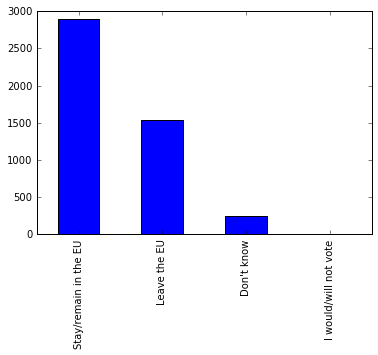

In [143]:
BES_Panel.loc[ld,"euRefVote"].value_counts().plot('bar')


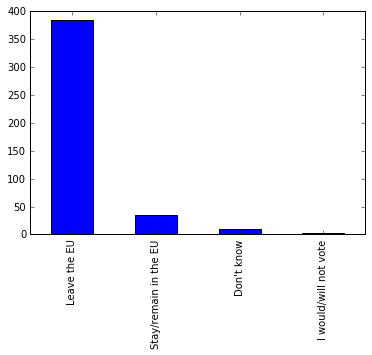

In [142]:
BES_Panel.loc[ld_ukip,"euRefVote"].value_counts().plot('bar')

In [153]:
overrun_errors

['euRefVote',
 'europeanness',
 'likeFarage',
 'likeBoris',
 'likeUKIP',
 'changeImmig',
 'EUIntegrationSelf',
 'ukCoopTrade',
 'ukCoopWorkers',
 'ukCoopMovement',
 'effectsEUUnemployment',
 'effectsEUTrade',
 'effectsEUImmigration',
 'effectsEUTerror',
 'euLeaveVoice',
 'effectsEUWorkers',
 'effectsEUEcon',
 'effectsEUNHS',
 'euLeaveBigBusiness',
 'britainFairShare',
 'euPreventWar',
 'euUKRich',
 'euCloser',
 'UKsovereignty',
 'turkey',
 'euParlOverRide',
 'euLawsLevel',
 'echr',
 'normEU',
 'euUndermineIdentity',
 'immigrantsWelfareState',
 'satDemEU',
 'immigEcon',
 'immigCultural',
 'asylumMore',
 'euMore',
 'familiesMore',
 'immigSelf',
 'recallVote15',
 'euRefVoteW9',
 'happyEULeaveW9',
 'likeFarageW9',
 'likeUKIPW9',
 'blameLeave_1W9',
 'blameLeave_2W9',
 'blameLeave_3W9',
 'blameLeave_4W9',
 'blameLeave_5W9',
 'blameLeave_6W9',
 'blameLeave_7W9',
 'blameLeave_8W9',
 'blameLeave_12W9',
 'blameLeave_99W9',
 'creditLeave_1W9',
 'creditLeave_2W9',
 'creditLeave_3W9',
 'creditLeave

In [202]:
BES_Panel.loc[ld].dtypes

id                                       int32
wt_core_W8                             float64
wt_core_W9                             float64
wt_full_W8                             float64
wt_full_W1W2W3W4W5W6W7                 float64
wt_full_W7                             float64
wt_full_W9                             float64
wt_full_W1W2W3W4W5W6W7W8W9             float64
wt_full_W7W8W9                         float64
wave9                                     int8
country                               category
generalElectionVote                   category
generalElectionVoteOth                  object
generalElectionVoteW9                 category
generalElectionVoteOthW9                object
partyId                               category
partyIdSqueeze                        category
partyIdSqueezeOth                       object
partyIdEU                             category
partyIdW9                             category
partyIdSqueezeW9                      category
partyIdSqueez

In [239]:
liberal_democats = BES_Panel[ BES_Panel.columns[ BES_Panel.dtypes =="category" ] ].apply(lambda x: x.cat.codes).loc[ld]
liberal_democats.replace(-1,np.nan, inplace=True)

In [240]:
%%time
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
X_filled_softimpute = SoftImpute().complete(liberal_democats)


Using Theano backend.


[SoftImpute] Max Singular Value of X_init = 15802.282995
[SoftImpute] Iter 1: observed MAE=1.144495 rank=21
[SoftImpute] Iter 2: observed MAE=1.127503 rank=20
[SoftImpute] Iter 3: observed MAE=1.120972 rank=19
[SoftImpute] Iter 4: observed MAE=1.117825 rank=18
[SoftImpute] Iter 5: observed MAE=1.114355 rank=18
[SoftImpute] Iter 6: observed MAE=1.112332 rank=18
[SoftImpute] Iter 7: observed MAE=1.110978 rank=18
[SoftImpute] Iter 8: observed MAE=1.109920 rank=18
[SoftImpute] Iter 9: observed MAE=1.108476 rank=17
[SoftImpute] Iter 10: observed MAE=1.106843 rank=17
[SoftImpute] Iter 11: observed MAE=1.105650 rank=17
[SoftImpute] Iter 12: observed MAE=1.104787 rank=17
[SoftImpute] Iter 13: observed MAE=1.104162 rank=17
[SoftImpute] Iter 14: observed MAE=1.103703 rank=17
[SoftImpute] Iter 15: observed MAE=1.103362 rank=17
[SoftImpute] Iter 16: observed MAE=1.103103 rank=17
[SoftImpute] Iter 17: observed MAE=1.102901 rank=17
[SoftImpute] Iter 18: observed MAE=1.102740 rank=17
[SoftImpute] Ite

In [246]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clean_feature_set_std = StandardScaler().fit_transform(X_filled_softimpute)
BES_std = pd.DataFrame(clean_feature_set_std,
                       columns = liberal_democats.columns,
                       index   = liberal_democats.index)


In [ ]:
# y = X["euRefVoteW8"]==1
# X = X.drop("euRefVoteW8",axis=1)
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)
# print( (X_r.shape, X_r2.shape ) )

In [265]:
# ['profile_past_vote_2010', 'profile_past_vote_2015']
lda = LinearDiscriminantAnalysis(n_components=2)
y = np.abs(BES_std['profile_past_vote_2015'].loc[ld]-1.299482)<0.1 # True for LD -> UKIP
X = BES_std.drop( ['profile_past_vote_2010', 'profile_past_vote_2015'],axis=1  )
X_r2 = lda.fit(X, y).transform(X)
print( X_r2.shape )

(4698, 1)


C:\ANACON~1\envs\BES_analysis\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [288]:
# colors = ['navy', 'turquoise', 'darkorange']
# target_names = ["LD -> not ukip", "LD -> ukip"]
# plt.figure()
# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('LDA of IRIS dataset')

# plt.show()

In [291]:
pd.DataFrame(lda.coef_.transpose(), index = X.columns ).sort_values(by=0)

,0
commonwealthCitizen,-150.539150
otherCitizen,-134.153326
country_of_residence1,-108.612584
ukCitizen,-41.816043
profile_oslaua,-29.945036
profile_gross_household,-26.759091
profile_gross_personal,-25.259724
ns_sec,-22.873652
EUIntegrationLD,-18.594198
EUIntegrationGreen,-18.526232


In [ ]:
# UKIP2015: less people in cities ukip
# Not UKIP2015: more people in cities

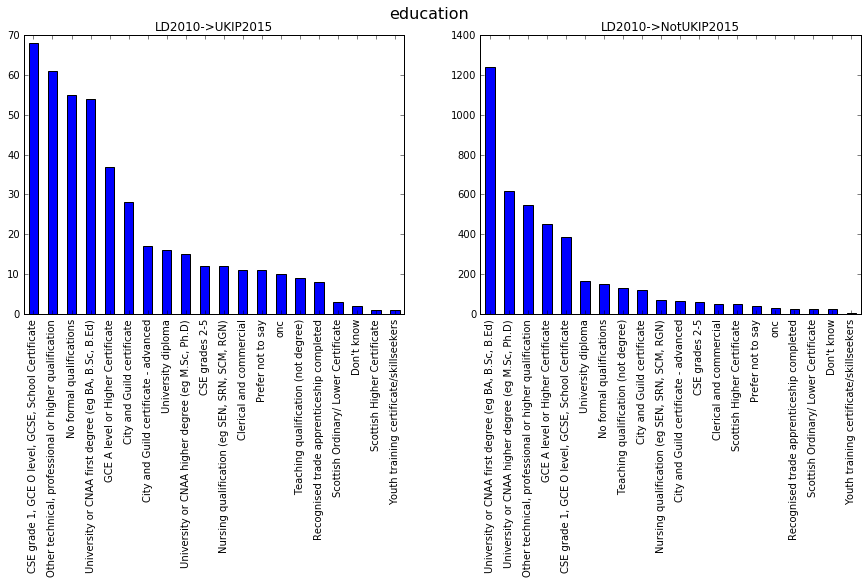

In [393]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'education'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

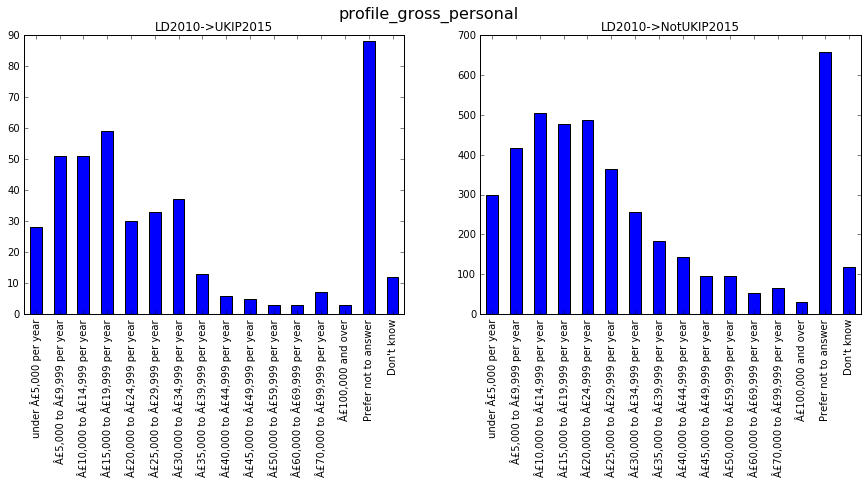

In [388]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'profile_gross_personal'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().sort_index().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().sort_index().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

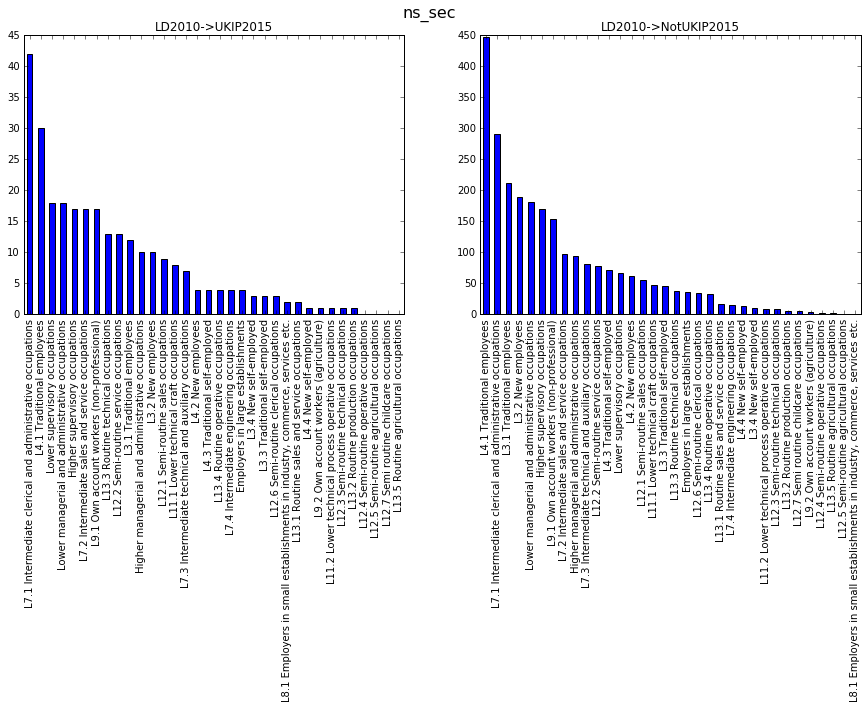

In [392]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'ns_sec'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

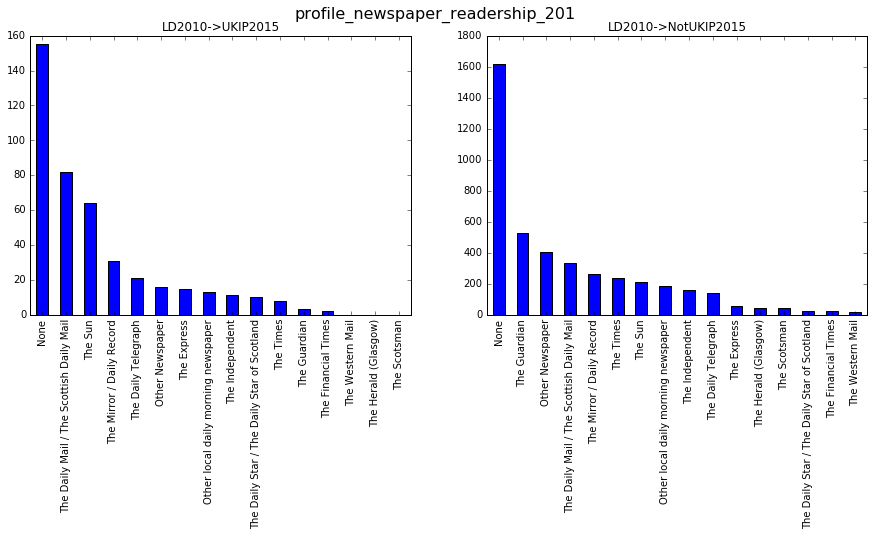

In [395]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'profile_newspaper_readership_201'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

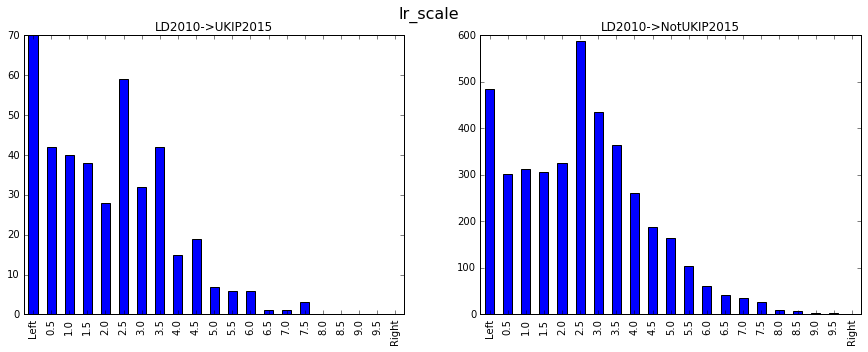

In [397]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'lr_scale'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().sort_index().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().sort_index().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

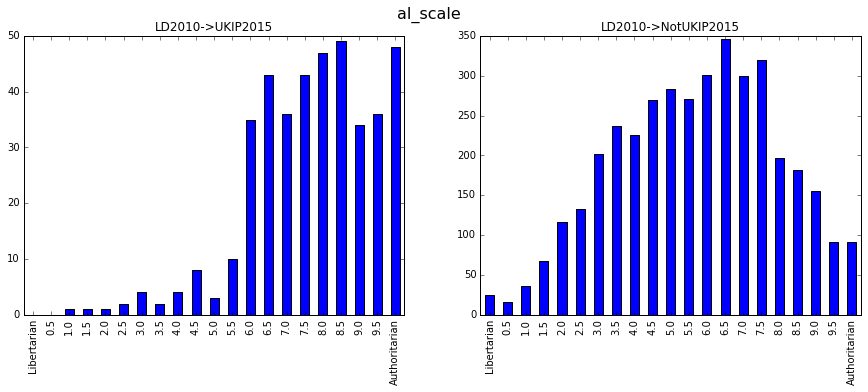

In [398]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'al_scale'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().sort_index().plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().sort_index().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

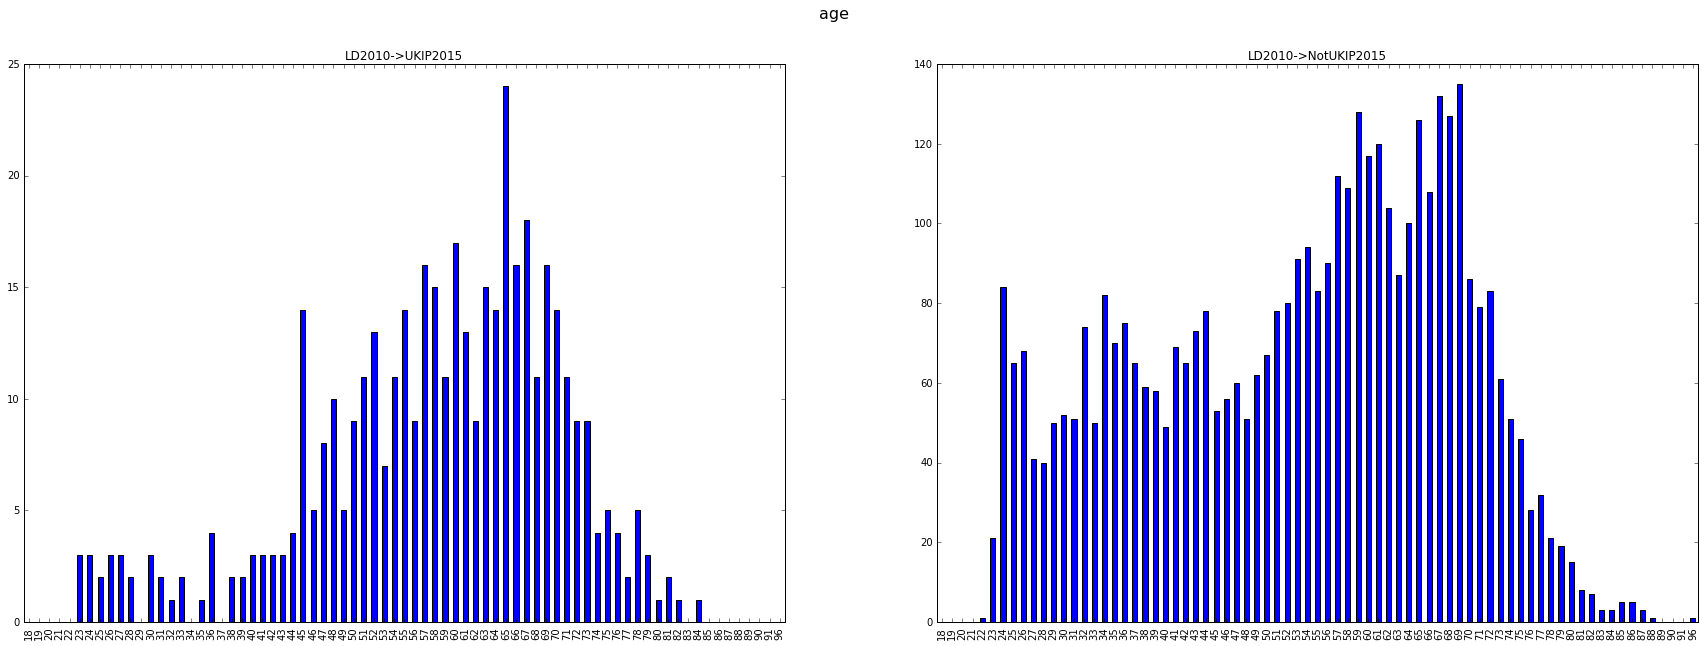

In [411]:
fig, axes = plt.subplots(1,2,figsize=(30,10))
col = 'age'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().sort_index().astype('int').plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().sort_index().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

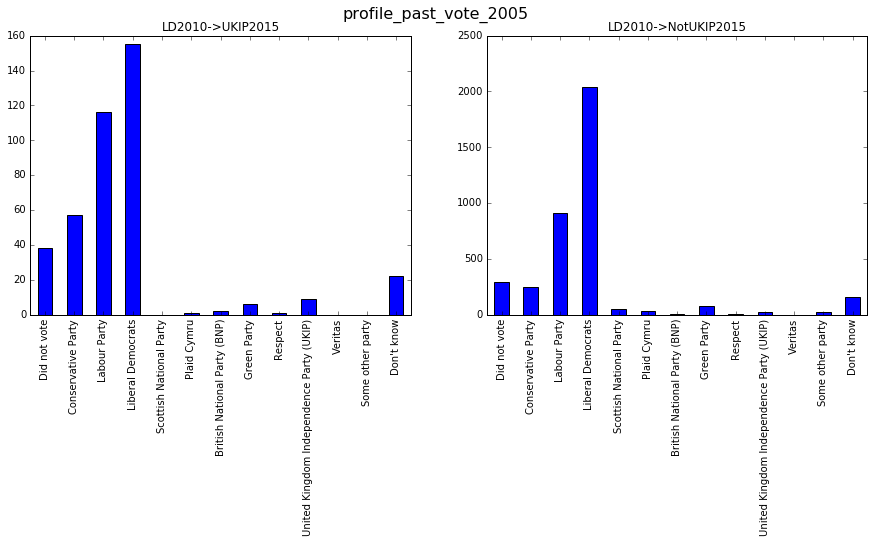

In [418]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
col = 'profile_past_vote_2005'
fig.suptitle(col, fontsize=16)
BES_Panel.loc[ld_ukip,col].value_counts().sort_index().astype('int').plot('bar', ax=axes[0], title = "LD2010->UKIP2015")
BES_Panel.loc[ld_minus_ukip,col].value_counts().sort_index().plot('bar', ax=axes[1], title = "LD2010->NotUKIP2015")

In [ ]:
# Create a dataset of 2010 libdems
# modify variable to be UKIP/NOT UKIP in 2015
# 'profile_past_vote_2015' == 5 is ukip

In [425]:
liberal_democats = BES_Panel[ BES_Panel.columns[ BES_Panel.dtypes =="category" ] ].apply(lambda x: x.cat.codes).loc[ld]

In [431]:
liberal_democats = liberal_democats.drop(['profile_past_vote_2010'], axis=1)

In [438]:
liberal_democats['LDUKIP2015'] = (liberal_democats['profile_past_vote_2015'].loc[ld]==5)

In [444]:
liberal_democats.fillna(-1).astype('float').to_stata("../BES_analysis_data/LiberalDemocats.dta")

In [474]:
# liberal_democats.fillna(-1).astype('float')

In [450]:
BES_min = pd.read_hdf("../BES_analysis_data/BESW8min.hdf", "BESW8min")

In [466]:
liberal_democats = BES_min.loc[ BES_min['profile_past_vote_2010']==3.0 ]

In [471]:
liberal_democats['LDUKIP2015'] = liberal_democats['profile_past_vote_2015']==5

C:\ANACON~1\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [475]:
# drop 'profile_past_vote_2010', 'profile_past_vote_2015', 'generalElectionVote'
liberal_democats = liberal_democats.drop(['profile_past_vote_2010', 'profile_past_vote_2015', 'generalElectionVote'], axis=1)

In [478]:
liberal_democats['LDUKIP2015'] = liberal_democats['LDUKIP2015'].astype('float')

In [480]:
liberal_democats.fillna(-1).to_stata("../BES_analysis_data/LiberalDemocats_small.dta")

In [485]:
W9_vars = [x for x in BES_min.columns if "W9" in x]
liberal_democats = liberal_democats.drop(W9_vars, axis=1)

In [486]:
liberal_democats.fillna(-1).to_stata("../BES_analysis_data/LiberalDemocats_small.dta")

In [490]:
# locus1      Many times I feel that I have little influence over the things that happen to me
# ○ Strongly disagree 1
# ○ Disagree 2
# ○ Neither agree nor disagree 3
# ○ Agree 4
# ○ Strongly agree 5
# ○ Don't know 9999


# subjClass   Do you ever think of yourself as belonging to any particular class?
# ○ Yes, middle class 1
# ○ Yes, working class 2
# ○ Yes, other (open [othSubjClass]) 3
# ○ No 4
# ○ Don't know 9999


liberal_democats["locus1"].value_counts()



3.0    1440
2.0     847
1.0     718
4.0     397
0.0      54
Name: locus1, dtype: int64

In [496]:
liberal_democats["subjClass"].value_counts()

1.0    1385
2.0    1380
0.0     803
Name: subjClass, dtype: int64

In [501]:
BES_Panel["subjClass"].loc[ld].cat.categories

Index(['No', 'Yes, middle class', 'Yes, working class', 'Yes, other',
       'Don't know'],
      dtype='object')

In [500]:
BES_Panel["subjClass"].loc[ld].value_counts()

Yes, middle class     1762
Yes, working class    1653
No                     989
Don't know             105
Yes, other              90
Name: subjClass, dtype: int64

In [497]:
liberal_democats["locus1"].corr( liberal_democats['LDUKIP2015']   )

0.10617365233247091

In [498]:
liberal_democats["subjClass"].corr( liberal_democats['LDUKIP2015']   )

0.13794378864915596

In [505]:
(liberal_democats["subjClass"]==2).corr( liberal_democats['LDUKIP2015']   )

0.19952622515751031

In [513]:
(liberal_democats["locus1"]==3).corr( liberal_democats['LDUKIP2015']   )

0.10129859363775745